## Detecting outliers using the rolling median

* **Rolling mean and Rolling standard deviation are not robust to outliers**
* **Rolling mean and Rolling standard deviation changes abruptly when outlier is in the window**
* **Outlier detection becomes very sensitive to choice of window-size and threshold**


#### Estimation method
datapoint is outlier if `ABS(actual - expectation)` is greater than the `threshold`

`ABS(y(t) - y_hat) > threshold`

## Rolling median
* **Median is robust to outliers**

#### We can use rolling median instead of rolling mean
#### What is an outlier robust alternative to rolling standard deviation ?

## Mean absolute Deviation
The median can be used instead of the mean to provide an outlier robust value for the expected value y_hat. However, we require an outlier robust estimator of the dispersion of a dataset to take the place of the standard deviation. 

The median absolute deviation, $MAD$, is an outlier robust estimator of the dispersion of a dataset.

 The $MAD$ is defined as:
$$ MAD = median(|y - median(y)|) $$



In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
 
from sktime.utils.plotting import plot_series

from statsmodels.tsa.seasonal import STL

## Example : Median is Robust to outliers !

In [18]:
# Example with an outlier
data_with_outlier = [1, 1, 1, 2, 2, 2, 1e6]

# let compute the stats
mean_of_data = np.mean(data_with_outlier)
std_of_data = np.std(data_with_outlier)
median_of_data = np.median(data_with_outlier)

median_absolute_deviation = np.median(np.abs(data_with_outlier - median_of_data))

print('Mean of Data', mean_of_data)
print('Std of Data', std_of_data)
print('Median of Data', median_of_data)
print('Median_absolute_deviation of Data', median_absolute_deviation)

Mean of Data 142858.42857142858
Std of Data 349926.5812215296
Median of Data 2.0
Median_absolute_deviation of Data 1.0


## Data Set Synopsis

The timeseries is between January 1992 and Apr 2005.

It consists of a single series of monthly values representing sales volumes. 

a monthly retail sales dataset (found [here](https://raw.githubusercontent.com/facebook/prophet/master/examples/example_retail_sales.csv)).

In [13]:
df = pd.read_csv('../../Datasets/example_retail_sales_with_outliers.csv', parse_dates=['ds'], index_col=['ds'])

plot_series(df)
plt.xticks(rotation=20);

<img src='./plots/retail-sales-with-outliers-df.png'>

## Outliers in timeseries data

* ### Point outliers
    * The individual points are outliers

* ### Level Shift Outliers
    * These are called Sub-sequence outliers because a consecutive section of timeseries are outliers
    * The baseline of timeseries undergoes abrupt shift 

* ### Transient Shift Outliers
    * These are called Sub-sequence outliers because a consecutive section of timeseries are outliers
    * The baseline of timeseries undergoes abrupt shift, but that shift is transient
    * The abrupt shift decays over-time hence transient

## Why are outliers a problem

* Outliers bias the model
* Time-series decomposition results are distorted if there are outliers
    * The trend computation using rolling-average give us inflated results, if there are outliers in the window
    * Outliers distorts classical seasonal decomposition result

## How to identify Outliers

#### 1. Visual Inspection
Plot the time series and inspect
* if the time series is small, then by visual inspection we can identify the outliers

#### 2. Estimation methods
`abs( y_true - y_hat ) > threshold`
* We can use rolling statitcs like mean, median to compute and expectation
* If the expection is very different from actual we can flag those points as outliers

#### 3. Density based methods
Does an observation has only a few neighbours ?
* Look at the neighbouring datapoints 
* If the neighbourhood is sparse we can flag them as outliers

## Lets use Estimation method 

#### rolling mean and standard-deviation  to identify outliers

In [14]:
# our data
df.plot();

<img src='./plots/retail-sales-with-outliers-df-plt.png'>

#### The seasonal spikes in the data are likely to be picked up as outliers. We shall de-seasonalise the data first using STL decomposition

In [15]:
res = STL(endog=df['y'], robust=True).fit()
res.plot();

<img src='./plots/stl-plot.png'>

In [16]:
deseasonalised = df['y']-res.seasonal
df['deseasonalised'] = deseasonalised
# plot the deseasonalized data
df.plot(y=['deseasonalised']);

<img src='./plots/deseasonalized-plot.png'>

### ROLLING STATISTICS -- ROLLING MEDIAN

#### Apply a window of data
#### Compute statistics from the data inside the window
#### Move the window and iterate through all the data

LETS USE ROLLING STATS

Compute yhat using a `rolling median` and the `rolling median absolute deviation` which will be used as part of the threshold

In [17]:
mean_abs_dev = lambda y: np.median(np.abs(y-np.median(y)))

In [81]:
def compute_rolling_stats(window_size=12, alpha_param=3.5):
   rolling_stats = (df['deseasonalised'].rolling(window=window_size, center=True, min_periods=1)
                                       .agg({
                                          'rolling_median':'median',
                                          'rolling_median_abs_dev': mean_abs_dev
                                       }))

   alpha = alpha_param
   is_outlier = np.abs(df['deseasonalised']-rolling_stats['rolling_median']) >  alpha*rolling_stats['rolling_median_abs_dev']

   upper_limit = rolling_stats['rolling_median'] + alpha*rolling_stats['rolling_median_abs_dev']
   lower_limit = rolling_stats['rolling_median'] - alpha*rolling_stats['rolling_median_abs_dev']

   return rolling_stats, is_outlier, upper_limit, lower_limit


rolling_stats, is_outlier, upper_limit, lower_limit = compute_rolling_stats(window_size=12, alpha_param=3.5)

In [86]:
def plot_results():
    ax = df.plot(y=['deseasonalised'], figsize=(15,10))
    rolling_stats.plot(y=['rolling_median'], ax=ax)
    df[is_outlier].plot(y=['deseasonalised'], linestyle='', marker='x', c='r', ax=ax, label=['outlier'])

    ax.fill_between(x=df.index, y1=upper_limit, y2=lower_limit, color='green', alpha=0.5)

plot_results()

<img src='./plots/outlier-detection-using-median.png'>

## We have detected the outliers 

* We no longer see the jumps in the computed statistics when there are outliers in the window
* We can that Means absolute deviation is increasing with the slope of the trend , which is not desirable
* Small deviations from the local behaviour is picked up, this can be resolved by adjusting the threshold
* Still have to remove the seasonality because seasonal spikes distorts the statistics

We can see some datapoints are classified as outliers between 1999 and 2004. Lets zoom in and observe

In [80]:
mask = df.query('index > 1999 and index < 2004').index

ax = df.loc[mask].plot(y=['deseasonalised'], figsize=(15,4))
rolling_stats.loc[mask].plot(y=['rolling_median'], ax=ax)
df.loc[mask][ is_outlier.loc[mask] ].plot(y=['deseasonalised'], linestyle='', marker='x', c='r', ax=ax, label=['outlier'])

ax.fill_between(x=df.loc[mask].index, y1=upper_limit.loc[mask], y2=lower_limit.loc[mask], color='green', alpha=0.3);

<img src='./plots/outlier-detection-using-median-zoom-in.png'>

#### Outliers between 1999 -- 2004
* Detected outlier are datapoints that deviates from the median-line
* We can clearly see that sensitvity of outlier detection depends on the trend
    * when the slope is steeper we can see a wider range for median-absolute-deviation
        * We can see the upper and lower bounds are wider and allowing more freedom to the datapoints
        * This is why datapoints around 2000, even though they deviate more from the median, are not classified as outliers
    * when the slope is not that steep we can see a narrow range for median-absolute-deviation
        * We can see a tight upper and lower bound when slope is not steep
        * This is why data-points between 2001 and 2002 that deviated from median are classified as outliers

#### We can adjust the upper and lower bounds by changing `window-size` and `alpha` parameters

In [88]:
# lets double the window-size and increase alpha to 5.0

rolling_stats, is_outlier, upper_limit, lower_limit = compute_rolling_stats(window_size=24, alpha_param=5.0)

plot_results()

<img src='./plots/outlier-detection-change-params.png'>

#### Outliers betweeen 1999 -- 2004

By increasing the upper and lower bounds, the data-points that perviously get classified as outliers are now acceptable.

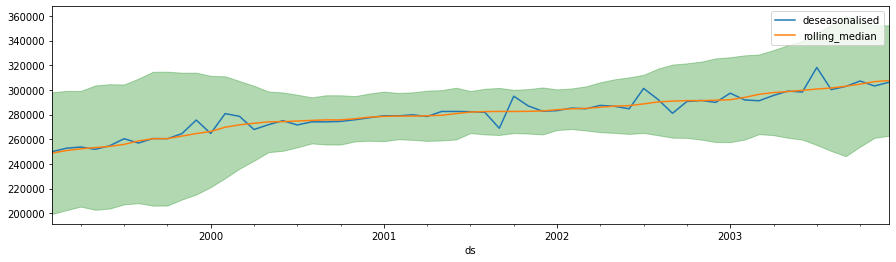

In [95]:
mask = df.query('index > 1999 and index < 2004').index

ax = df.loc[mask].plot(y=['deseasonalised'], figsize=(15,4))
rolling_stats.loc[mask].plot(y=['rolling_median'], ax=ax)

if any(df.loc[mask][ is_outlier.loc[mask]  ]['y']):
    df.loc[mask][ is_outlier.loc[mask] ].plot(y=['deseasonalised'], linestyle='', marker='x', c='r', ax=ax, label=['outlier'])

ax.fill_between(x=df.loc[mask].index, y1=upper_limit.loc[mask], y2=lower_limit.loc[mask], color='green', alpha=0.3);

## Methods for handling outliers


#### 1. MODELING OUTLIERS
Suppose the have the flower sales data from a store and we find the flower sales on Feb 14 very high on visual inspection. Is this and outliers ?

From visual inspection its clear that the sales on feb-14 is very high compared to the rest.

Since Feb 14 is valentine's day we know there will be increase in the flower sales

This case can be modeled 

We can add a feature to our model. Eg: Like zero for all other days and 1 for valentines day

We can teach our model about events like valentines-day where we expect a high sale of flowers 



#### 2. IMPUTATION 
#### Treat the outliers as missing data and Impute them using imputation methods 

imputation methods
* forward fill `pandas.DataFrame.fillna(method='ffill')`
* backward fill `pandas.DataFrame.fillna(method='bfill')` 
* linear-interpolation `pandas.DataFrame.interpolate(method='linear')`
* STL decomposition and interpolation


In [121]:
# lets mark the outliers as NaN

df_with_nan = df.loc[:,['y']].copy()
df_with_nan.loc[is_outlier] = np.NaN

df_with_nan.isna().sum()

y    4
dtype: int64

## STL decomposition and interpolation

In [122]:
# STL cant work with data that has missing so impute them with linear interplation
y = df_with_nan.interpolate(method='linear')
# Now extract the seasonal component
res = STL(endog=y, period=12, robust=True).fit()
seasonal_component = res.seasonal
# deseasonalize
df_deseason = df_with_nan['y'] - seasonal_component
# inpute the missing
df_imputed = df_deseason.interpolate(method='linear')
# add back the seasonal pattern
df_imputed = df_imputed + seasonal_component

In [155]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15,8))

df.plot(y=['y'], ax=ax[0])
df[is_outlier].plot(y=['y'], linestyle='', marker='x', color='red', ax=ax[0], label=['outlier'])

df_imputed.plot(y=['y'], ax=ax[1])
df_imputed.loc[is_outlier].plot(linestyle='', marker='o', color='red', ax=ax[1], alpha=0.5)
ax[1].legend(['y','imputed'])

plt.suptitle('Treat the outliers as missing data and Impute them using imputation method ')

<img src='./plots/outlier-detection-treat-as-missing-and-impute.png'>